In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.seasonal import DecomposeResult, seasonal_decompose
import numpy as np
import pywt
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller

# **Prédiction du Volume de Trafic sur l'I-94 (Minneapolis-St Paul)**
**Dataset :** [Metro Interstate Traffic Volume](https://archive.ics.uci.edu/dataset/492/metro+interstate+traffic+volume)  
Ce jeu de données provient de la plateforme **UCI Machine Learning Repository** et contient des données horaires sur le volume de trafic de l'autoroute I-94 uniquement en direction ouest de Minneapolis à St Paul.
Il inclut plusieurs facteurs pouvant influencer le trafic, tels que :  
- **Les conditions météorologiques** (température, précipitations, etc.)  
- **Les jours fériés et événements spéciaux**  

L'objectif de cette étude est de **prédire** le volume de trafic horaire en fonction des caractéristiques disponibles. Une telle prédiction pourrait faciliter la gestion du trafic, anticiper les embouteillages et contribuer à une meilleure planification urbaine.

En outre, cette analyse nous aidera à mieux **comprendre** l'impact des variables contextuelles et à identifier les tendances sous-jacentes de cette série temporelle.


## **1. Import et mise en forme de la donnée**

In [2]:
df = pd.read_csv(r'data\Metro_Interstate_Traffic_Volume.csv.gz', compression='gzip')
print(df.shape)
df.head(5)

(48204, 9)


holiday    temp  rain_1h  snow_1h  clouds_all weather_main  \
0     NaN  288.28      0.0      0.0          40       Clouds   
1     NaN  289.36      0.0      0.0          75       Clouds   
2     NaN  289.58      0.0      0.0          90       Clouds   
3     NaN  290.13      0.0      0.0          90       Clouds   
4     NaN  291.14      0.0      0.0          75       Clouds   

  weather_description            date_time  traffic_volume  
0    scattered clouds  2012-10-02 09:00:00            5545  
1       broken clouds  2012-10-02 10:00:00            4516  
2     overcast clouds  2012-10-02 11:00:00            4767  
3     overcast clouds  2012-10-02 12:00:00            5026  
4       broken clouds  2012-10-02 13:00:00            4918

Nous avons identifié certaines observations dupliquées (au même pas de temps), où les volumes de trafic sont similaires, seules les variables météorologiques varient. Afin d'éviter toute redondance, nous supprimerons ces observations en conservant uniquement la première occurrence.

In [3]:
df.drop_duplicates(subset=['date_time'], keep='first', inplace=True)
print(df.shape)

(40575, 9)


In [4]:
missing_percentage = (df.isna().sum() / len(df)) * 100
rounded_missing_percentage = round(missing_percentage, 2)
print(rounded_missing_percentage[rounded_missing_percentage > 0])

holiday    99.87
dtype: float64


A priori, aucune valeur manquante n’est présente, à l’exception de la colonne **holiday**, bien que cela semble simplement indiquer l’absence de jours fériés.

Néanmoins, certaines données sont absentes de manière implicite, car les timestamps ne sont pas continus. Autrement dit, il manque des observations pour certains jours et certaines heures.  
Regardons celà plus en détail:

In [5]:
df['date_time'] = pd.to_datetime(df['date_time'])
start, end = df['date_time'].min(), df['date_time'].max()
full_range = pd.date_range(start=start, end=end, freq='h')

missing_timestamps = full_range.difference(df['date_time'])

print("Timestamps manquants :")
print(len(missing_timestamps) / len(full_range) * 100)


gaps = (missing_timestamps[1:] - missing_timestamps[:-1]) != pd.Timedelta(hours=1)
gap_indices = [0] + (gaps.nonzero()[0] + 1).tolist() + [len(missing_timestamps)]

longest_gap = max(
    (missing_timestamps[gap_indices[i]:gap_indices[i+1]] for i in range(len(gap_indices)-1)),
    key=len
)

print("\nLa plus longue période de données manquantes est de", len(longest_gap), "heures : entre le", longest_gap.min(), "et le", longest_gap.max())

missing_by_year = pd.Series(missing_timestamps).dt.year.value_counts().sort_index()
print("\nValeurs manquantes par années")
print(missing_by_year)

Timestamps manquants :
22.78929040360792

La plus longue période de données manquantes est de 7386 heures : entre le 2014-08-08 02:00:00 et le 2015-06-11 19:00:00

Valeurs manquantes par années
2012      72
2013    1466
2014    4259
2015    5167
2016     946
2017      47
2018      19
Name: count, dtype: int64


On observe une quantité importante de valeurs manquantes entre **2013 et 2015**, avec une interruption particulièrement longue de près d'un an, entre **août 2014 et juin 2015**.

Au total, près de **23%** des données sont manquantes, rendant toute tentative d'imputation non seulement risquée, mais surtout incohérente compte tenu de cette absence prolongée.

Afin de garantir la qualité des analyses, nous choisissons donc d'exclure la première moitié du dataset et de ne conserver qu'environ les 3,5 dernières années.  
Étant donné la taille initiale du dataset, cette réduction ne compromet pas la quantité de données disponibles, nous permettant ainsi de poursuivre une modélisation fiable.

In [6]:
df = df[(df["date_time"] >= "2015-10-27 07:00:00")]
print("Nombre d'observations (non manquantes) après tronquage : ", df.shape[0])
start, end = df['date_time'].min(), df['date_time'].max()
full_range = pd.date_range(start=start, end=end, freq='h')
print("Etendue du jeu de données : ", len(full_range))

missing_timestamps = full_range.difference(df['date_time'])

print("\nTimestamps manquants :")
print(len(missing_timestamps) / len(full_range) * 100)

gaps = (missing_timestamps[1:] - missing_timestamps[:-1]) != pd.Timedelta(hours=1)
gap_indices = [0] + (gaps.nonzero()[0] + 1).tolist() + [len(missing_timestamps)]

longest_gap = max(
    (missing_timestamps[gap_indices[i]:gap_indices[i+1]] for i in range(len(gap_indices)-1)),
    key=len
)

print("\nLa plus longue période de données manquantes est de", len(longest_gap), "heures : entre le", longest_gap.min(), "et le", longest_gap.max())


# missing value per year
missing_by_year = (pd.Series(missing_timestamps).dt.year.value_counts()).sort_index()
print(missing_by_year)

Nombre d'observations (non manquantes) après tronquage :  23979
Etendue du jeu de données :  25672

Timestamps manquants :
6.594733561857276

La plus longue période de données manquantes est de 9 heures : entre le 2017-02-13 16:00:00 et le 2017-02-14 00:00:00
2015    681
2016    946
2017     47
2018     19
Name: count, dtype: int64


Ces différentes transformations nous laissera donc avec un jeu de données de presque 26 000 observations horaires lorsque nous aurons complété les pas de temps manquants.

## **2.Remplissage des valeurs manquantes**

- **Jours fériés** : Remplacés par `'None'`, indiquant l’absence de jours fériés.  
- **Variable catégorielle** : Remplissage avec la valeur la plus proche (avant ou après).  
- **Variables continues** dont le **volume de traffic** : Interpolation linéaire pour lisser les données sans rupture brutale.  

L'interpolation linéaire consiste à estimer une valeur manquante en traçant une ligne droite entre deux valeurs connues.  
Elle repose sur l'équation d'une droite entre deux points :  

\[  
    y = y_1 + \frac{(y_2 - y_1)}{(x_2 - x_1)} \times (x - x_1)
\]

où :  
- \( x_1, y_1 \) et \( x_2, y_2 \) sont les points encadrant la valeur manquante,  
- \( x \) est la position du point à estimer,  
- \( y \) est la valeur interpolée.  

In [7]:
full_df = pd.DataFrame({'date_time': full_range})
df = full_df.merge(df, on='date_time', how='left')
df['holiday'] = df['holiday'].fillna('None')
df[['temp', 'rain_1h', 'snow_1h', 'clouds_all']] = df[['temp', 'rain_1h', 'snow_1h', 'clouds_all']].interpolate(method='linear')
df[['weather_main', 'weather_description']] = df[['weather_main', 'weather_description']].ffill().bfill()
df.set_index("date_time", inplace=True)
df['traffic_volume'] = df['traffic_volume'].interpolate(method='linear')

print(df.isna().sum().sum())
print(len(df))

0
25672


## **3. Analyse exploratoire des données**

**A quoi ressemble nos variables?**

In [8]:
df.describe()

temp       rain_1h       snow_1h    clouds_all  traffic_volume
count  25672.000000  25672.000000  25672.000000  25672.000000    25672.000000
mean     281.707215      0.427575      0.000284     43.853381     3308.275962
std       12.469646     61.361121      0.008459     39.123228     1961.371753
min      243.390000      0.000000      0.000000      0.000000        0.000000
25%      272.590000      0.000000      0.000000      1.000000     1309.375000
50%      282.700000      0.000000      0.000000     40.000000     3503.500000
75%      292.074000      0.000000      0.000000     90.000000     4936.000000
max      310.070000   9831.300000      0.510000    100.000000     7280.000000

La température présente une grande variabilité, avec une moyenne de 8,5°C, un minimum de -29,76°C et un maximum de 36,92°C, reflétant des conditions climatiques contrastées.  
La couverture nuageuse, avec une moyenne de 43,85 %, indique une alternance entre périodes ensoleillées et nuageuses.  
Les précipitations restent généralement faibles, bien que la valeur maximale de pluie enregistrée (9831,3 mm) puisse indiquer des anomalies ou erreurs dans les données. La neige est quasi inexistante avec une moyenne de 0,000284 mm par heure.  
Enfin, le volume de trafic affiche une forte variation, avec une moyenne de 3308 véhicules et un écart-type élevé (1961), illustrant des fluctuations importantes entre les heures creuses et les périodes de pointe.

**Comment évolue le traffic sur la période d'étude?**

Text(0.5, 1.0, 'Traffic Volume Over Time')

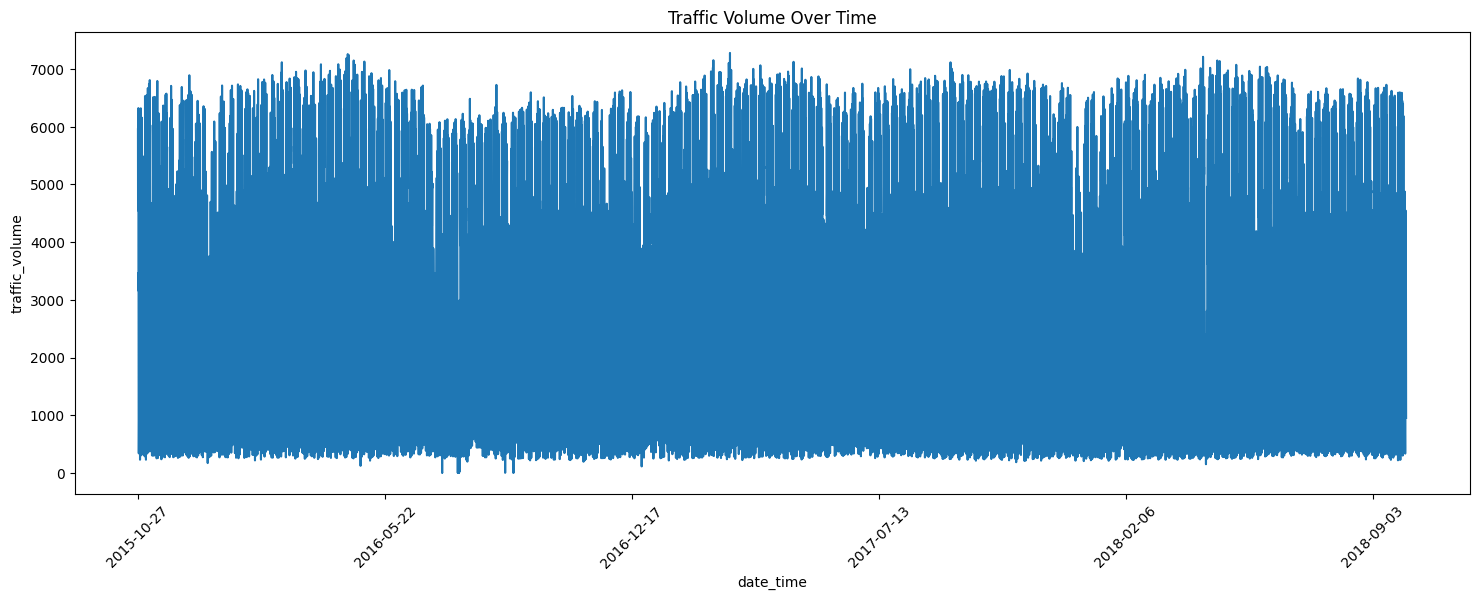

In [9]:
plt.figure(figsize=(18, 6))
sns.lineplot(x=df.index, y='traffic_volume', data=df)
plt.xticks(df.index[::5000], rotation=45)
plt.title('Traffic Volume Over Time')

- Présence de **pics** et de **creux** récurrents, reflétant des **cycles journaliers** et **hebdomadaires** caractéristiques des schémas de trafic urbain.
- **Pas de tendance nette à la hausse ou à la baisse** sur l’ensemble de la période. Une analyse plus fine sur des plages temporelles spécifiques pourrait révéler des tendances saisonnières ou des variations structurelles du trafic.

Les données étant denses, il est difficile de repérer des tendances ou des patterns intéressants. Pour améliorer la visualisation, nous allons utiliser des techniques de lissage des données, telles que la moyenne mobile (rolling window average) et la décomposition en ondelettes (wavelet decomposition).

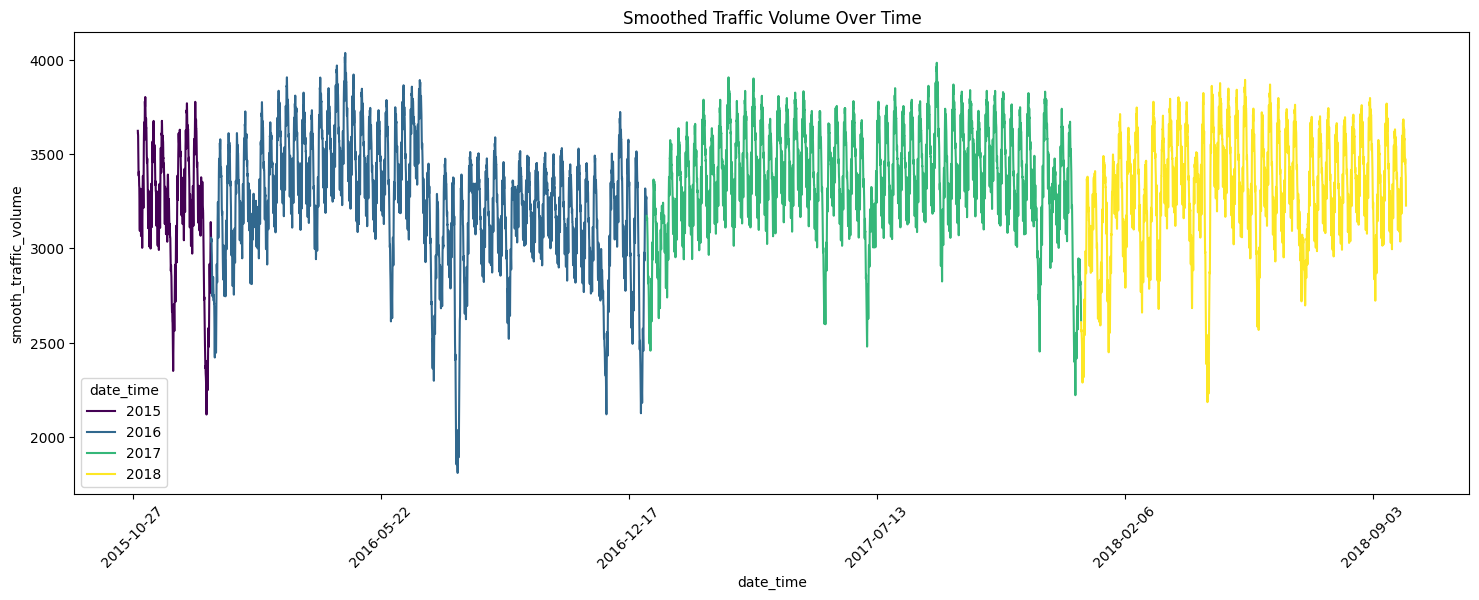

In [10]:
df['smooth_traffic_volume'] = df['traffic_volume'].rolling(window=100).mean()
colors = df.index.year
plt.figure(figsize=(18, 6))
sns.lineplot(x=df.index, y='smooth_traffic_volume', data=df, hue=colors, palette='viridis')
plt.xticks(df.index[::5000], rotation=45)
plt.title('Smoothed Traffic Volume Over Time')
plt.show()

- Des **cycles saisonniers** récurrents sont visibles, caractérisés par des **pics réguliers** correspondant probablement aux **jours ouvrés** et des **creux** associés aux **week-ends** ou **jours fériés**.

Text(0.5, 1.0, 'Wavelet Decomposition')

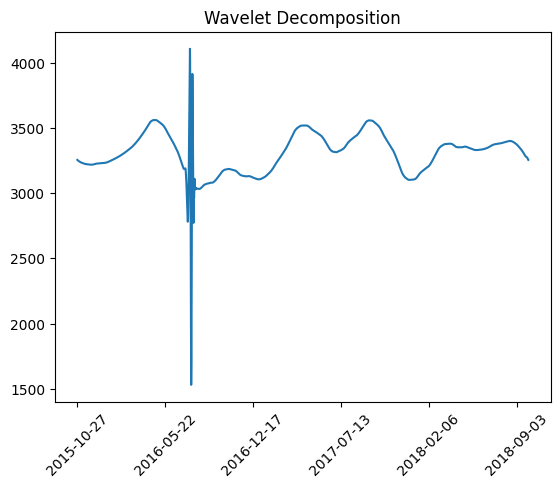

In [11]:
traffic_volume = df['traffic_volume']
coeff = pywt.wavedec(traffic_volume, 'db4', mode="per")
mean_coeff = np.mean([abs(ele - np.mean(traffic_volume)) for ele in traffic_volume])
sigma = (1 / 0.6745) * mean_coeff
threshhold = sigma * np.sqrt(2 * np.log(len(traffic_volume)))
coeff[1:] = (pywt.threshold(i, value=threshhold, mode='hard') for i in coeff[1:])
traffic_volume_wavelet_decomp = pywt.waverec(coeff, 'db4', mode='per')

plt.plot(df.index, traffic_volume_wavelet_decomp)
plt.xticks(df.index[::5000], rotation=45)
plt.title('Wavelet Decomposition')


La décomposition en ondelette est une technique utilisée en traitement du signal et en analyse de données pour décomposer un signal en composantes de fréquence différentes.  

Les ondelettes sont des fonctions mathématiques qui permettent de représenter des données ou des fonctions en termes de composantes de fréquence à différentes échelles. La transformation en ondelettes utilise des fonctions de base localisées dans le temps et la fréquence.

- La courbe met en évidence des **fluctuations de bas niveau** représentant la tendance de fond du volume de trafic.
- On observe des **oscillations régulières** correspondant à des cycles saisonniers ou des variations périodiques sur le long terme.
- Une **forte volatilité** est visible autour de la période de mi-2016, caractérisée par des **pics extrêmes** et des **variations soudaines**. En effet, un certain saut (baissier) est visible dans les données lissées à cette même période.

**Peut-on observer des différences entre les différents horizons temporels (mois, jour, heure...)?**

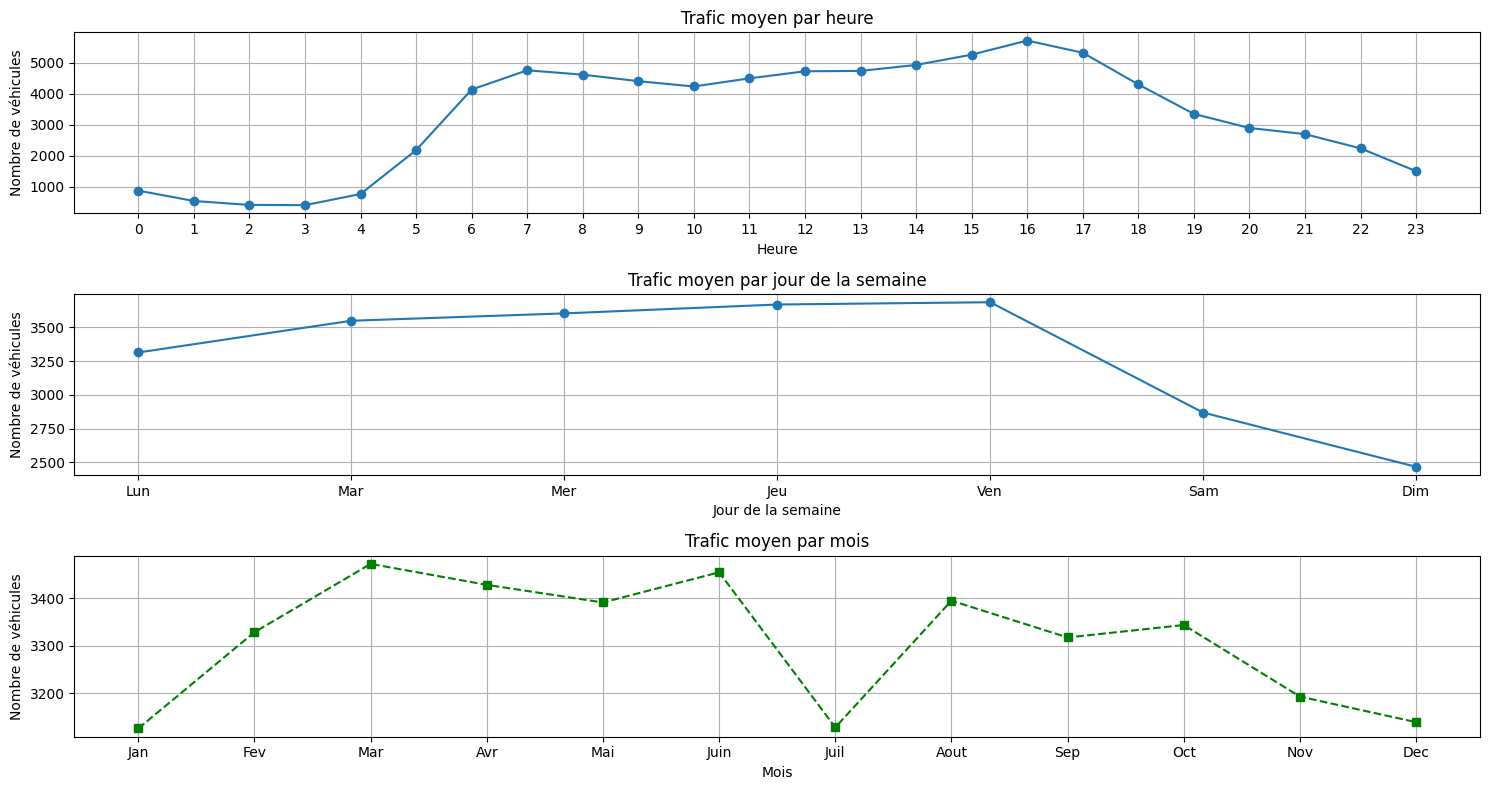

In [12]:
df["Hour"] = df.index.hour
df["Day"] = df.index.dayofweek 
df["Month"] = df.index.month

hourly_traffic = df.groupby("Hour")["traffic_volume"].mean()
daily_traffic = df.groupby("Day")["traffic_volume"].mean()
monthly_traffic = df.groupby("Month")["traffic_volume"].mean()

fig, axes = plt.subplots(3, 1, figsize=(15, 8))

axes[0].plot(hourly_traffic.index, hourly_traffic.values, marker='o')
axes[0].set_title("Trafic moyen par heure")
axes[0].set_xlabel("Heure")
axes[0].set_ylabel("Nombre de véhicules")
axes[0].grid(True)
axes[0].set_xticks(hourly_traffic.index)


axes[1].plot(daily_traffic.index, daily_traffic.values, marker='o', linestyle='-')
axes[1].set_xticks(range(7))
axes[1].set_xticklabels(["Lun", "Mar", "Mer", "Jeu", "Ven", "Sam", "Dim"])
axes[1].set_title("Trafic moyen par jour de la semaine")
axes[1].set_xlabel("Jour de la semaine")
axes[1].set_ylabel("Nombre de véhicules")
axes[1].grid(True)

axes[2].plot(monthly_traffic.index, monthly_traffic.values, marker='s', linestyle='--', color='g')
axes[2].set_title("Trafic moyen par mois")
axes[2].set_xlabel("Mois")
axes[2].set_ylabel("Nombre de véhicules")
axes[2].set_xticks(monthly_traffic.index)
axes[2].set_xticklabels(["Jan", "Fev", "Mar", "Avr", "Mai", "Juin", "Juil", "Aout", "Sep", "Oct", "Nov", "Dec"])
axes[2].grid(True)

plt.tight_layout()
plt.show()

Ces trois graphiques illustrent l’évolution du **trafic moyen** en fonction de l'heure, du jour de la semaine et du mois. Cette analyse permet de mieux comprendre les schémas de trafic récurrents et d’identifier les périodes de forte ou faible affluence.

**Trafic Moyen par Heure**

- Le trafic est **très faible entre minuit et 5h du matin**, avec un minimum autour de 3h.
- À partir de **6h**, une forte augmentation est observée, atteignant un **pic entre 7h et 8h**, correspondant à l’**heure de pointe matinale**.
- Un second **pic significatif vers 16h-17h**, typique des **heures de sortie de bureau**.
- Le trafic diminue progressivement après 18h, pour revenir à des niveaux bas en fin de soirée.
- Ce schéma est caractéristique d’un trafic influencé par des **déplacements domicile-travail**.

**Trafic Moyen par Jour de la Semaine**

- Le **trafic est le plus élevé du lundi au vendredi**, avec un **pic le jeudi et vendredi**, signe d’une activité intense en semaine.
- Le **week-end (samedi et dimanche)** enregistre une **baisse significative du trafic**, en particulier le dimanche, jour de trafic le plus faible.
- La différence nette entre semaine et week-end reflète un trafic dominé par les **activités professionnelles** en semaine et des déplacements plus sporadiques le week-end.

**Trafic Moyen par Mois**

- Le trafic reste **relativement stable tout au long de l'année**, avec quelques variations :
  - **Pic en mars et juin**, indiquant des périodes d’activité plus soutenue.
  - **Baisse notable en juillet et août**, probablement en raison des **vacances d’été**.
  - Légère diminution du trafic en décembre, en lien avec les **fêtes de fin d'année**.

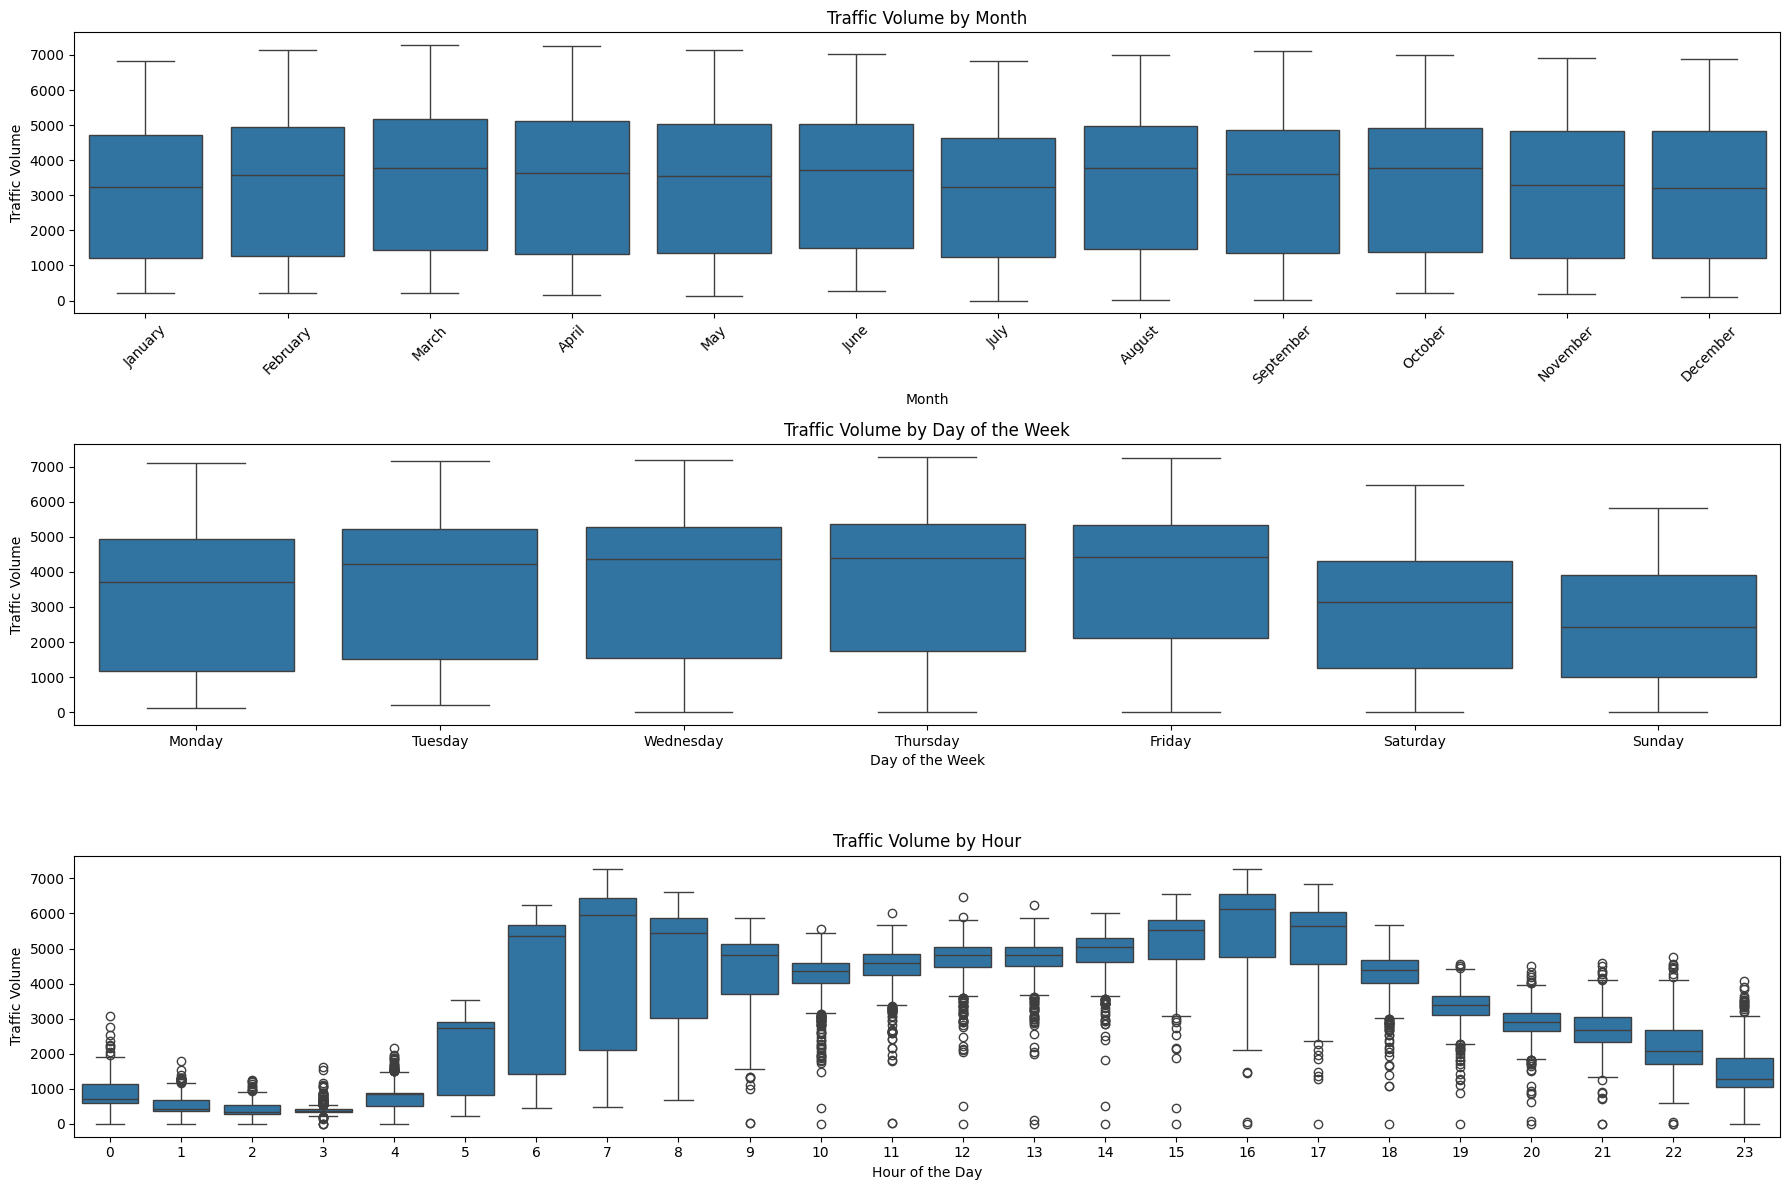

In [13]:
df['Month'] = pd.Categorical(df.index.month_name(), categories=["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], ordered=True)

df['Day'] = pd.Categorical(df.index.day_name(), categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], ordered=True)
df['Hour'] = df.index.hour

fig, axes = plt.subplots(3, 1, figsize=(18, 12)) 

sns.boxplot(x='Month', y='traffic_volume', data=df, ax=axes[0])
axes[0].set_title('Traffic Volume by Month')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Traffic Volume')
axes[0].tick_params(axis='x', rotation=45)

sns.boxplot(x='Day', y='traffic_volume', data=df, ax=axes[1])
axes[1].set_title('Traffic Volume by Day of the Week')
axes[1].set_xlabel('Day of the Week')
axes[1].set_ylabel('Traffic Volume')

sns.boxplot(x='Hour', y='traffic_volume', data=df, ax=axes[2])
axes[2].set_title('Traffic Volume by Hour')
axes[2].set_xlabel('Hour of the Day')
axes[2].set_ylabel('Traffic Volume')

plt.tight_layout()
plt.show()


Les boxplots nous donnent certaines informations supplémentaires concernant la distribution du trafic selon la temporalité.

**Mois**
  - Les **écarts interquartiles (IQR)** sont similaires, montrant une **dispersion modérée** du trafic chaque mois.
  - **Présence d'outliers** dans tous les mois, reflétant des pics de trafic exceptionnels, possiblement liés à des événements ponctuels.

**Jours**
  - La **dispersion est plus importante en semaine**, ce qui peut indiquer des variations liées aux heures de pointe.
  - **Moins de variabilité le week-end**, probablement en raison de schémas de trafic plus homogènes et moins soumis aux contraintes horaires.
  - Des **outliers fréquents** en semaine, souvent associés à des pics de trafic inattendus (accidents, événements spéciaux, conditions météo).

**Heures**
  - Forte **dispersion pendant les heures de pointe**, signe de fluctuations importantes dues aux conditions de circulation.
  - Moins de variabilité en dehors des heures de pointe, notamment la nuit.
  - De nombreux **outliers identifiés en dehors des heures de pointe**, probablement dus à des événements imprévus affectant ponctuellement le trafic.

**La météo influence-t-elle le traffic?**

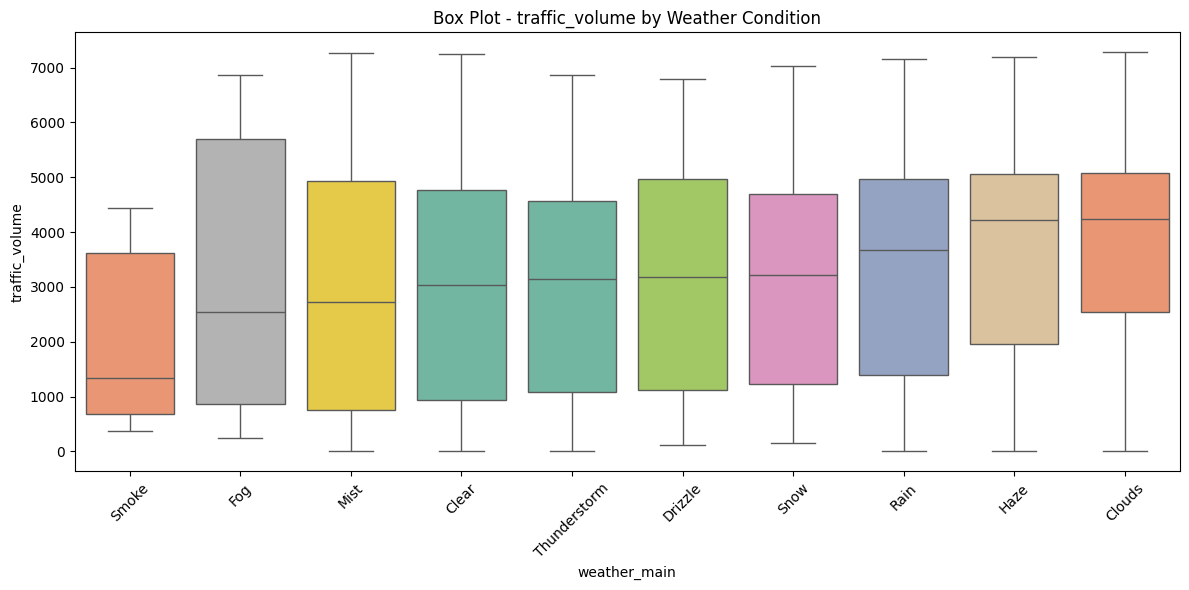

In [14]:
plt.figure(figsize=(12, 6))
sorted_weather = df.groupby('weather_main')['traffic_volume'].median().sort_values().index
sns.boxplot(x='weather_main', y='traffic_volume', hue='weather_main', data=df, order=sorted_weather, palette='Set2', legend=False)
plt.title('Box Plot - traffic_volume by Weather Condition')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Le volume de trafic est relativement **variable** en fonction des conditions météorologiques.  
**Dispersion du traffic :**
  - **Mist, Fog, Haze** : Présentent des écarts interquartiles (IQR) importants, indiquant une **grande variabilité du trafic**.
  - **Thunderstorm** et **Snow** : Affichent des **outliers fréquents**, suggérant des pics de trafic inhabituels en raison d'événements exceptionnels (accidents, ralentissements, etc.).
  - **Clear** et **Clouds** : La distribution est plus **concentrée**, signe d’une circulation plus prévisible par temps clair ou nuageux.

**Volume du traffic :**
- Le **volume de trafic médian le plus élevé** est observé sous des conditions de **Clouds** et de **Haze**.
- Le **volume de trafic le plus faible** est constaté par temps de **Smoke** (fumée), suivi de conditions de **Mist** et de **Fog**.

**Conclusions :**
- **Clouds et Haze** sont des conditions météo courantes, ce qui peut expliquer des volumes de trafic élevés.
- Le faible volume de trafic lors de conditions de **Smoke** peut être dû à des situations exceptionnelles (incendies, pollution dense) qui limitent la mobilité des véhicules.
- La **pluie (Rain)** et la **neige (Snow)** n’ont pas un impact négatif aussi important que prévu sur le volume médian, bien que la **dispersion** des valeurs (observée dans le boxplot) indique des effets ponctuels plus marqués.

**Est-il possible de décomposer le trafic en composantes saisonnières ?**

In [15]:
result = seasonal_decompose(df["traffic_volume"], model='additive')

def plot_seasonal_decompose(result: DecomposeResult, title="Seasonal Decomposition"):
    return (
        make_subplots(
            rows=3,
            cols=1,
            subplot_titles=["Trend", "Seasonal", "Residuals"],
        )
        .add_trace(
            go.Scatter(x=result.trend.index, y=result.trend, mode="lines"),
            row=1,
            col=1,
        )
        .add_trace(
            go.Scatter(x=result.seasonal.index, y=result.seasonal, mode="lines"),
            row=2,
            col=1,
        )
        .add_trace(
            go.Scatter(x=result.resid.index, y=result.resid, mode="lines"),
            row=3,
            col=1,
        )
        .update_layout(
            height=900, title=title, margin=dict(t=100), title_x=0.5, showlegend=False
        )
    )

plot_seasonal_decompose(result).show()

Cette décomposition saisonnière permet d'analyser le volume de trafic à travers ses différentes composantes : **tendance**, **saisonnalité**, et **résidus**. L'objectif est de comprendre la structure sous-jacente des données et d'identifier des motifs récurrents ou des anomalies.

- La **tendance à long terme** est relativement stable avec quelques perturbations ponctuelles.
- Le volume de trafic est fortement influencé par des **cycles saisonniers réguliers** (quotidiens et hebdomadaires). *Il faut zoomer pour les voir.*
- Les **résidus** mettent en évidence des anomalies non capturées par la décomposition. Cela pourrait être dû à une variabilité du trafic en fonction d'autres facteurs comme les jours fériés, les événements spéciaux ou les conditions météorologiques.

**Les données présentent-elles un comportement autorégressif ?**

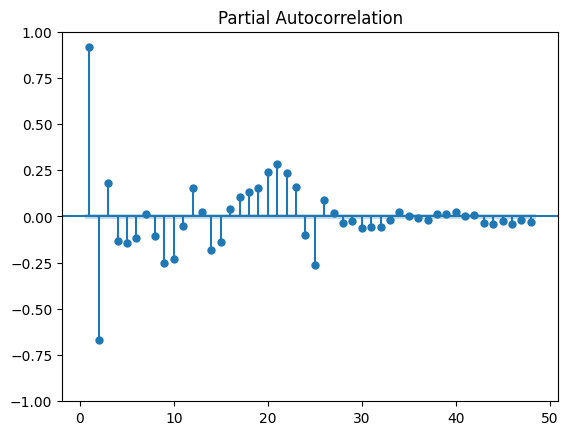

In [16]:
plot_pacf(df["traffic_volume"], lags=48, zero=False)
plt.show()

- Forte dépendance à court terme sur les lags 1 à 4.
- Effets saisonniers marqués, avec une forte autocorrélation autour du lag 24, probablement liée aux cycles quotidiens.
- La décroissance progressive de la corrélation confirme des schémas répétitifs à plusieurs échelles temporelles.  


Pour la modélisation, intégrer les lags proches et ceux de la veille comme variables prédictives permettrait d’enrichir l’information capturée par les modèles.

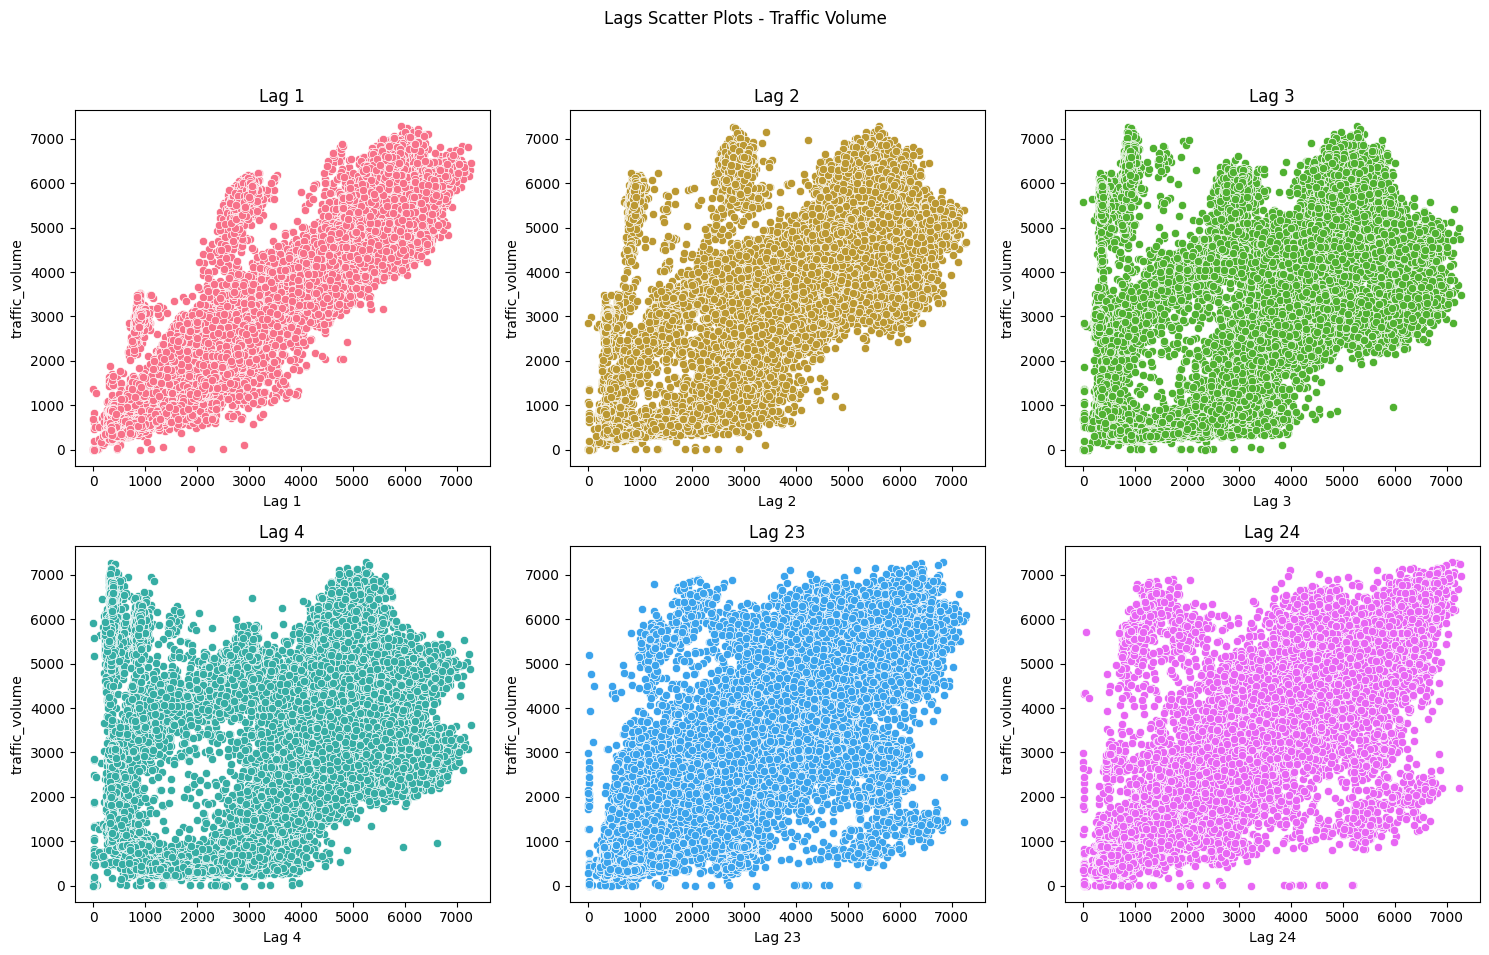

In [17]:
lags = [1, 2, 3, 4, 23, 24]
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Lags Scatter Plots - Traffic Volume')

for i, lag in enumerate(lags):
    ax = axs[i//3, i%3]
    lagged_data = df['traffic_volume'].shift(lag)
    sns.scatterplot(
        x=lagged_data, 
        y=df['traffic_volume'], 
        ax=ax,
        color=sns.color_palette("husl", len(lags))[i]
    )
    ax.set_title(f'Lag {lag}')
    ax.set_xlabel(f'Lag {lag}')
    ax.set_ylabel('traffic_volume')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

  - Forte **corrélation positive** visible, avec des points formant un nuage dense le long d’une diagonale ascendante.
  - Cela indique une **dépendance temporelle significative à court terme**, typique des séries temporelles avec des cycles de trafic réguliers (heures de pointe).


**Est ce que la série temporelle est stationnaire?**

In [35]:
result = adfuller(df['traffic_volume'])
adf_statistic = result[0]
p_value = result[1]
critical_values = result[4]
print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
if p_value < 0.05:
    print('La série est stationnaire')


ADF Statistic: -21.978407757903522
p-value: 0.0
La série est stationnaire


## **3. Features engineering**

Grâce à l'analyse exploratoire, nous avons obtenu des insights précieux nous permettant de tester différentes techniques de feature engineering afin d'ajouter de l'information pertinente et d'améliorer la capacité prédictive de nos modèles.

**Intégration des lags dans nos variables explicatives**   
Nous choisissons d'inclure les valeurs des heures proches de l'heure 
𝑡
t afin de capturer les tendances immédiates, tout en ajoutant les valeurs de trafic des heures correspondantes de la veille pour exploiter d'éventuelles régularités journalières et améliorer la précision des prédictions.

In [18]:
lags = [1, 2, 3, 4, 23, 24]
for lag in lags:
    df[f'lag_{lag}'] = df['traffic_volume'].shift(lag)
df.dropna(inplace=True)

**Rajout de statistiques sur des fenêtres glissantes**  
L’ajout de statistiques sur des fenêtres glissantes permet d’extraire des tendances locales et d’enrichir le modèle avec des informations contextuelles.
- Capture des tendances récentes : Moyennes, médianes ou tendances sur 3, 6 ou 24 heures permettent d’anticiper les variations de trafic.
- Réduction de la volatilité : Moyennes et écarts-types lissent les fluctuations et modélisent les comportements sous-jacents.
- Détection d’anomalies : Valeurs extrêmes et écarts-types élevés signalent des événements inhabituels.
- Exploitation des effets saisonniers : Fenêtres de 24h ou une semaine capturent les cycles quotidiens et hebdomadaires.
- Robustesse du modèle : Intégrer plusieurs horizons temporels améliore la généralisation des modèles ML/DL.

In [19]:
# Moyenne mobile
df['rolling_mean_daily'] = df['traffic_volume'].rolling(window=24).mean()         
df['rolling_mean_weekly'] = df['traffic_volume'].rolling(window=24*7).mean()      
df['rolling_mean_monthly'] = df['traffic_volume'].rolling(window=24*30).mean()    

# Médiane mobile
df['rolling_median_daily'] = df['traffic_volume'].rolling(window=24).median()         
df['rolling_median_weekly'] = df['traffic_volume'].rolling(window=24*7).median()      
df['rolling_median_monthly'] = df['traffic_volume'].rolling(window=24*30).median()   

# Écart-type mobile
df['rolling_std_daily'] = df['traffic_volume'].rolling(window=24).std()           
df['rolling_std_weekly'] = df['traffic_volume'].rolling(window=24*7).std()        
df['rolling_std_monthly'] = df['traffic_volume'].rolling(window=24*30).std()     

**Extraction de variables temporelles (Jour de la semaine, mois, week-end...)**  
L’analyse exploratoire montre que le trafic varie selon le jour, le mois et les périodes spécifiques (week-ends, jours fériés). Les jours ouvrés présentent des schémas distincts des week-ends, tandis que les mois et saisons influencent la densité du trafic (ex. : vacances, fêtes). Intégrer ces variables permet d’affiner la prédiction en capturant ces tendances récurrentes.

In [20]:
df['Weekend'] = df.index.dayofweek.isin([5, 6]).astype(int)

Les variables temporelles comme le jour de la semaine, le mois ou l’heure sont cycliques : après le dimanche vient le lundi, après décembre vient janvier. Un encodage classique (0 à 6 pour les jours, 1 à 12 pour les mois) ne reflète pas cette continuité.  

L’encodage cyclique (via sinus et cosinus) préserve cette relation en transformant une variable périodique en coordonnées sur un cercle, permettant au modèle de percevoir la proximité entre le début et la fin du cycle.

Ainsi, les jours voisins ont des valeurs similaires et le modèle comprend la continuité du cycle.

In [21]:
df['Hour_sin'] = np.sin(2 * np.pi * df.index.hour / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df.index.hour / 24)

df['Day_sin'] = np.sin(2 * np.pi * df.index.dayofweek / 7)
df['Day_cos'] = np.cos(2 * np.pi * df.index.dayofweek / 7)

df['Month_sin'] = np.sin(2 * np.pi * df.index.month / 12)
df['Month_cos'] = np.cos(2 * np.pi * df.index.month / 12)

In [22]:
df.columns

Index(['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
       'weather_description', 'traffic_volume', 'smooth_traffic_volume',
       'Hour', 'Day', 'Month', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_23',
       'lag_24', 'rolling_mean_daily', 'rolling_mean_weekly',
       'rolling_mean_monthly', 'rolling_median_daily', 'rolling_median_weekly',
       'rolling_median_monthly', 'rolling_std_daily', 'rolling_std_weekly',
       'rolling_std_monthly', 'Weekend', 'Hour_sin', 'Hour_cos', 'Day_sin',
       'Day_cos', 'Month_sin', 'Month_cos'],
      dtype='object')

In [23]:
# autres features qu'on crée pas pour l'instant

# df['is_rain'] = (df['rain_1h'] > 0).astype(int)
# df['is_snow'] = (df['snow_1h'] > 0).astype(int)
# df['is_clear'] = (df['weather_main'] == 'Clear').astype(int)
# df['temp_rain_interaction'] = df['temp'] * df['is_rain']
# df['temp_snow_interaction'] = df['temp'] * df['is_snow']

# #index thermique
# df['heat_index'] = df['temp'] - 0.55 * (1 - df['clouds_all']/100) * (df['temp'] - 14.5)

# # transformation de box-cox et differenciation
# df['traffic_volume_boxcox'], _ = boxcox(df['traffic_volume'] + 1)  

# df['traffic_volume_diff'] = df['traffic_volume'].diff()
# df['traffic_volume_diff2'] = df['traffic_volume_diff'].diff()

**Choix des features et suppression des valeurs manquantes induites par la création de features**

In [24]:
df.dropna(inplace=True)
features = ['weather_main', 'traffic_volume', 
       'Hour', 'Day', 'Month', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_23',
       'lag_24', 'rolling_mean_daily', 'rolling_mean_weekly',
       'rolling_mean_monthly', 'rolling_median_daily', 'rolling_median_weekly',
       'rolling_median_monthly', 'rolling_std_daily', 'rolling_std_weekly',
       'rolling_std_monthly', 'Weekend', 'Hour_sin', 'Hour_cos', 'Day_sin',
       'Day_cos', 'Month_sin', 'Month_cos']

df = df.loc[:, features]
print(df.shape)
df.head()

(24854, 27)


weather_main  traffic_volume  Hour     Day     Month  \
date_time                                                                  
2015-11-30 10:00:00         Snow          3930.0    10  Monday  November   
2015-11-30 11:00:00         Snow          3998.5    11  Monday  November   
2015-11-30 12:00:00         Mist          4067.0    12  Monday  November   
2015-11-30 13:00:00         Mist          4444.0    13  Monday  November   
2015-11-30 14:00:00         Haze          4821.0    14  Monday  November   

                      lag_1   lag_2   lag_3   lag_4  lag_23  ...  \
date_time                                                    ...   
2015-11-30 10:00:00  4081.5  4233.0  3863.5  3494.0  3592.5  ...   
2015-11-30 11:00:00  3930.0  4081.5  4233.0  3863.5  4021.0  ...   
2015-11-30 12:00:00  3998.5  3930.0  4081.5  4233.0  4187.0  ...   
2015-11-30 13:00:00  4067.0  3998.5  3930.0  4081.5  4454.0  ...   
2015-11-30 14:00:00  4444.0  4067.0  3998.5  3930.0  4841.0  ...   

                     rolling_std_daily  rolling_std_weekly  \
date_time                                                    
2015-11-30 10:00:00        1637.969149         1816.195929   
2015-11-30 11:00:00        1647.317671         1813.057101   
2015-11-30 12:00:00        1648.663578         1809.027584   
2015-11-30 13:00:00        1657.951194         1807.179586   
2015-11-30 14:00:00        1674.072419         1804.217107   

                     rolling_std_monthly  Weekend      Hour_sin  Hour_cos  \
date_time                                                                   
2015-11-30 10:00:00          1943.630821        0  5.000000e-01 -0.866025   
2015-11-30 11:00:00          1942.010185        0  2.588190e-01 -0.965926   
2015-11-30 12:00:00          1941.111678        0  1.224647e-16 -1.000000   
2015-11-30 13:00:00          1941.018564        0 -2.588190e-01 -0.965926   
2015-11-30 14:00:00          1941.257375        0 -5.000000e-01 -0.866025   

                     Day_sin  Day_cos  Month_sin  Month_cos  
date_time                                                    
2015-11-30 10:00:00      0.0      1.0       -0.5   0.866025  
2015-11-30 11:00:00      0.0      1.0       -0.5   0.866025  
2015-11-30 12:00:00      0.0      1.0       -0.5   0.866025  
2015-11-30 13:00:00      0.0      1.0       -0.5   0.866025  
2015-11-30 14:00:00      0.0      1.0       -0.5   0.866025  

[5 rows x 27 columns]

## **3(bis). Encodage des variables catégorielles et train/test split**

In [25]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [37]:
# correlation_matrix = df_encoded.corr()
# plt.figure(figsize=(12, 5))
# sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap='coolwarm')
# plt.title("Correlation Matrix")
# plt.show()

In [36]:
X = df.drop(columns=['traffic_volume'])
y = df['traffic_volume']

train_size = int(0.8 * len(df_encoded))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

## **4. Modélisation**